In [1]:
import numpy as np
import cv2 as cv

In [2]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")

In [3]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [4]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))
images[0].shape

(75, 75, 3)

In [5]:
def avg_image(image):
    avg_kernel = np.ones((3,3), dtype=np.float32)
    avg_kernel /= 9
    return cv.filter2D(image, -1, avg_kernel)

In [6]:
def window_locations(r=2):
    x = [-r, 0, r]
    y = [-r, 0, r]
    mask = np.zeros((1+2*r,1+2*r))
    
    for xc in x:
        for yc in y:
            mask[r + yc, r + xc] = 1.0
    return np.tile(mask,(3,1,1)).T
    
window_mask = window_locations()

In [7]:
def extract_features(image, r=2):
    #grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    
    kernel = window_locations(r)
    (kH, kW) = kernel.shape[:2]

    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW, 27), dtype="float32")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual selection by taking the
            # element-wise multiplicate between the ROI and
            # the kernel
            k = (roi * kernel)

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad, :] = k[np.nonzero(kernel)]
    
    # return the output image
    return output

In [8]:
from scipy import ndimage

def std_image(image):
    average = avg_image(image)
    x2_min_avg = (image - average) * (image - average);
    avg_kernel_3d = np.ones((3, 3, 3), dtype=np.float32)
    avg_kernel_3d /= 9
    conv_image = ndimage.convolve(x2_min_avg, avg_kernel_3d, np.float32) 
    return np.sqrt(conv_image)

In [9]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())


In [10]:
std = std_image(images[0])
import matplotlib.pyplot as plt
%matplotlib inline

std.dtype

dtype('float32')

In [11]:
def get_features(image):
    avg = avg_image(image)
    std = std_image(image)
    
    avg_output2 = extract_features(avg)
    std_output2 = extract_features(std)
    
    avg_output4 = extract_features(avg, 4)
    std_output4 = extract_features(std, 4)
    return np.concatenate((avg_output2, std_output2, avg_output4, std_output4), axis=2)

In [12]:
def get_features_for(images):
    feature_list = []
    for image in images:
        feature_list.append(get_features(image))
    return np.array(feature_list)

X = get_features_for(images)
X.shape

(120, 75, 75, 108)

In [13]:
pixel_features = X.reshape(120*75*75, 108)
pixel_features.shape

(675000, 108)

In [14]:
pixel_masks = mask_images.reshape(120*75*75)
pixel_masks.shape

(675000,)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixel_features, pixel_masks, test_size = 0.20)

In [16]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     91710
         255       0.96      0.94      0.95     43290

   micro avg       0.97      0.97      0.97    135000
   macro avg       0.96      0.96      0.96    135000
weighted avg       0.97      0.97      0.97    135000



In [20]:
accuracy_score(y_test, predictions)

0.9669185185185185

In [18]:
confusion_matrix(y_test, predictions)

array([[89992,  1718],
       [ 2748, 40542]])

In [34]:
im_features = get_features_for([images[1]])
im_features = im_features.reshape(75*75, 108)

In [35]:
im_pred = clf.predict(im_features)
im_pred.shape

(5625,)

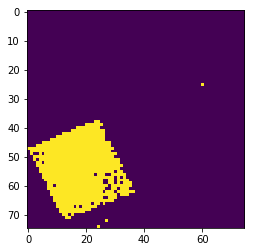

In [36]:
prediction_image = im_pred.reshape(75, 75)
plt.imshow(prediction_image)